In [44]:
pip install pandas huggingface_hub fsspec scikit-learn tqdm matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

tqdm.pandas()


In [46]:
# Login using e.g. `huggingface-cli login` to access this dataset
df = pd.read_json("hf://datasets/imnim/multiclass-email-classification/email_dataset.json")

df.head()

,subject,body,labels
0,Meeting Reminder: Quarterly Sales Review Tomorrow,"Dear Team, Just a friendly reminder that our Q...","[Business, Reminders]"
1,Meeting Confirmation for Tomorrow,"Dear Team, This is just a friendly reminder th...","[Business, Events & Invitations]"
2,Important Update: New Company Policies,"Dear Team, I hope this email finds you well. I...",[Business]
3,Important Update: Project Deadline Extension,"Dear Team, I hope this message finds you well....","[Business, Reminders]"
4,Monthly Finance Report,"Dear Team, Please find attached the monthly fi...","[Business, Finance & Bills]"


### Data exploration

In [47]:
# Basic info
print("Rows:", len(df))
print("Columns:", list(df.columns))

Rows: 2105
Columns: ['subject', 'body', 'labels']



Unique labels: ['Business', 'Reminders', 'Events & Invitations', 'Finance & Bills', 'Travel & Bookings', 'Customer Support', 'Newsletters', 'Personal', 'Job Application', 'Promotions']

Label counts:
labels
Business                941
Events & Invitations    656
Reminders               343
Finance & Bills         334
Travel & Bookings       314
Customer Support        227
Personal                221
Newsletters             199
Job Application         122
Promotions              120
Name: count, dtype: int64


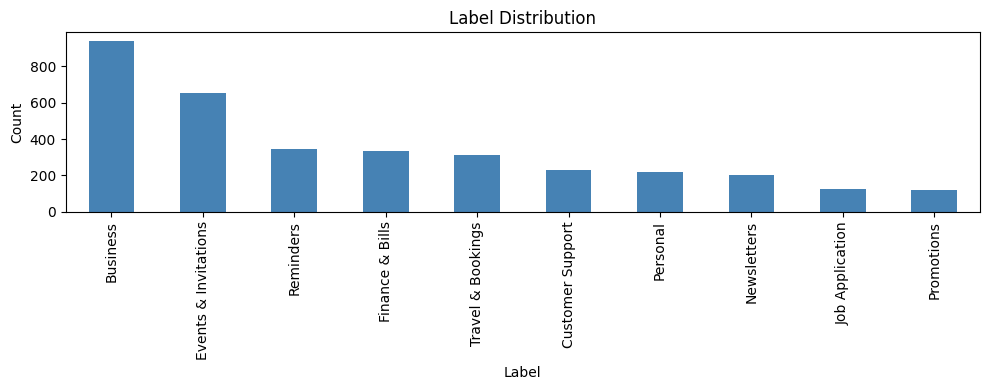

In [48]:
# Unique labels and their counts
labels_series = df['labels'].explode()
unique_labels = pd.unique(labels_series)
print("\nUnique labels:", list(unique_labels))

label_counts = labels_series.value_counts()
print("\nLabel counts:")
print(label_counts)

plt.figure(figsize=(10, 4))
label_counts.plot(kind='bar', color='steelblue')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Number of labels per email (value counts):
labels
1    983
2    872
3    250
Name: count, dtype: int64


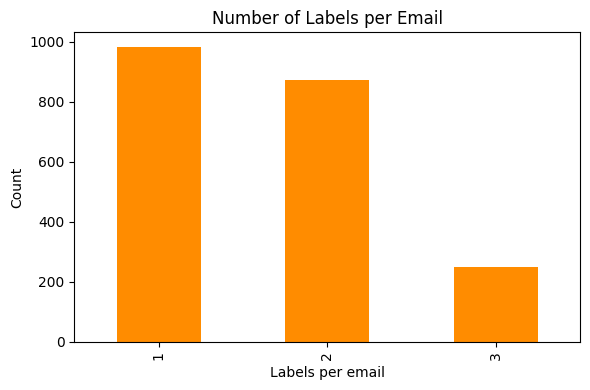

In [49]:
# Number of labels per email
def count_labels(x):
    if isinstance(x, (list, tuple, set)):
        return len(x)
    return 1

num_labels = df['labels'].apply(count_labels)
print("\nNumber of labels per email (value counts):")
print(num_labels.value_counts())

plt.figure(figsize=(6, 4))
num_labels.value_counts().sort_index().plot(kind='bar', color='darkorange')
plt.title('Number of Labels per Email')
plt.xlabel('Labels per email')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Text length stats:
count    2105.000000
mean      394.183373
std        61.134448
min       220.000000
25%       350.000000
50%       394.000000
75%       437.000000
max       605.000000
Name: body, dtype: float64


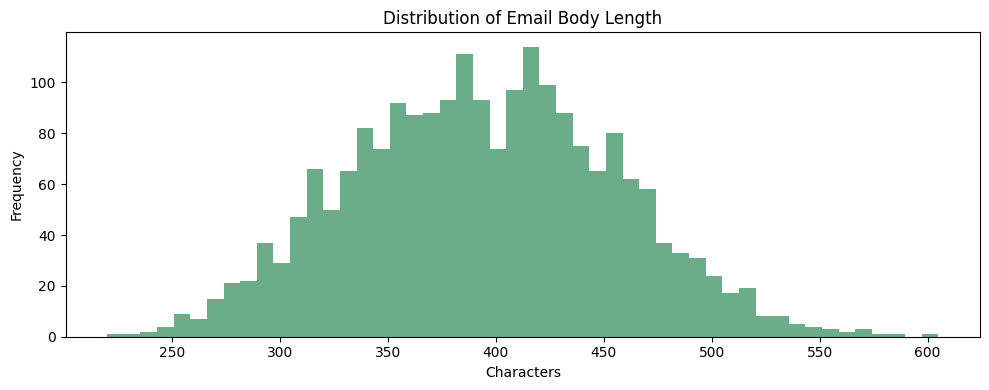

In [50]:
# body length distribution
text_len = df['body'].str.len()
print("\nText length stats:")
print(text_len.describe())

plt.figure(figsize=(10, 4))
text_len.plot(kind='hist', bins=50, color='seagreen', alpha=0.7)
plt.title('Distribution of Email Body Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [51]:
# Top subjects (optional quick look)
print("\nTop subjects (by frequency):")
print(df['subject'].value_counts().head(10))


Top subjects (by frequency):
subject
Upcoming Team Building Event                        150
Confirmation of Flight Booking                      124
Reminder: Upcoming Team Meeting                      88
Upcoming Team Meeting Agenda                         76
Regarding Your Recent Job Application                66
Upcoming Webinar on Digital Marketing Strategies     51
Reminder: Upcoming Payment Due                       43
Upcoming Payment Reminder                            41
Upcoming Company Event: Save the Date!               34
Important Update: Meeting Rescheduled                33
Name: count, dtype: int64


### Merge subject and body

In [52]:
df['text'] = df['subject'] + ' ' + df['body']

### Preprocessing

In [53]:
target = df['labels']
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

mlb = MultiLabelBinarizer()

target_binarized = mlb.fit_transform(target)
label_names = mlb.classes_

labels_df = pd.DataFrame(target_binarized, columns=label_names)

df = pd.concat([df, labels_df], axis=1)
df = df.drop('labels', axis=1)
df.head()

,subject,body,text,Business,Customer Support,Events & Invitations,Finance & Bills,Job Application,Newsletters,Personal,Promotions,Reminders,Travel & Bookings
0,Meeting Reminder: Quarterly Sales Review Tomorrow,"Dear Team, Just a friendly reminder that our Q...",Meeting Reminder: Quarterly Sales Review Tomor...,1,0,0,0,0,0,0,0,1,0
1,Meeting Confirmation for Tomorrow,"Dear Team, This is just a friendly reminder th...","Meeting Confirmation for Tomorrow Dear Team, T...",1,0,1,0,0,0,0,0,0,0
2,Important Update: New Company Policies,"Dear Team, I hope this email finds you well. I...",Important Update: New Company Policies Dear Te...,1,0,0,0,0,0,0,0,0,0
3,Important Update: Project Deadline Extension,"Dear Team, I hope this message finds you well....",Important Update: Project Deadline Extension D...,1,0,0,0,0,0,0,0,1,0
4,Monthly Finance Report,"Dear Team, Please find attached the monthly fi...","Monthly Finance Report Dear Team, Please find ...",1,0,0,1,0,0,0,0,0,0


In [54]:
# required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/I568645/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/I568645/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I568645/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/I568645/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text: str):
    """Lowercase, remove non-alphanumeric chars, tokenize, remove stopwords, lemmatize.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # eeplace non-alphanumeric characters with space
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # tokenize
    tokens = nltk.word_tokenize(text)
    # remove stopwords & very short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # lemmatize
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(lemmas), lemmas


result_series = df['text'].progress_apply(preprocess)
df[['clean_text', 'tokens']] = result_series.apply(pd.Series)

df[['text','clean_text', 'tokens']].head()


100%|██████████| 2105/2105 [00:00<00:00, 5076.24it/s]


,text,clean_text,tokens
0,Meeting Reminder: Quarterly Sales Review Tomor...,meeting reminder quarterly sale review tomorro...,"[meeting, reminder, quarterly, sale, review, t..."
1,"Meeting Confirmation for Tomorrow Dear Team, T...",meeting confirmation tomorrow dear team friend...,"[meeting, confirmation, tomorrow, dear, team, ..."
2,Important Update: New Company Policies Dear Te...,important update new company policy dear team ...,"[important, update, new, company, policy, dear..."
3,Important Update: Project Deadline Extension D...,important update project deadline extension de...,"[important, update, project, deadline, extensi..."
4,"Monthly Finance Report Dear Team, Please find ...",monthly finance report dear team please find a...,"[monthly, finance, report, dear, team, please,..."


In [56]:
# remove rows where clean_text is empty or tokens is an empty list
mask = (
    df['clean_text'].notna() &
    df['tokens'].notna() &
    (df['clean_text'].str.strip() != "") &
    df['tokens'].apply(lambda t: isinstance(t, list) and len(t) > 0)
)
removed_count = len(df) - mask.sum()
df = df[mask].copy()

print(f"Rows removed: {removed_count}; Remaining: {len(df)}")

Rows removed: 0; Remaining: 2105


In [57]:
data = df['tokens']

target_labels = ['Business', 'Reminders', 'Events & Invitations', 'Finance & Bills', 'Travel & Bookings', 'Customer Support', 'Newsletters', 'Personal', 'Job Application', 'Promotions']
target = df[target_labels]

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=0.2,
    random_state=42
)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    preprocessor=identity_tokenizer, # Skip preprocessing
    tokenizer=identity_tokenizer,      # Use the pre-tokenized list
    token_pattern=None
) 

X_train_tfidf = vectorizer.fit_transform(X_train)

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

# Initialize the base classifier (Multinomial Naive Bayes)
mnb = MultinomialNB()

# Initialize the OneVsRestClassifier wrapper
# This trains 10 independent MNB models, one for each label
ovr_classifier = OneVsRestClassifier(mnb)

# Train the model using the TF-IDF features and the binary labels
print("Starting training...")
ovr_classifier.fit(X_train_tfidf, y_train)
print("Training complete.")

Starting training...
Training complete.


In [60]:
X_test_tfidf = vectorizer.transform(X_test)


# Probability Scores (The likelihood of each label being present)


# This is useful for analyzing confidence and setting custom thresholds
y_pred_proba = ovr_classifier.predict_proba(X_test_tfidf)

In [61]:
# --- Threshold grid search for multilabel prediction ---


import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score, f1_score, hamming_loss, accuracy_score


thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]


rows = []


for th in thresholds:
    y_bin = (y_pred_proba >= th).astype(int)
    # ensure at least one label per sample
    row_sums = y_bin.sum(axis=1)
    no_label_rows = np.where(row_sums == 0)[0]
    if len(no_label_rows) > 0:
        top_indices = np.argmax(y_pred_proba[no_label_rows], axis=1)
        for r, c in zip(no_label_rows, top_indices):
            y_bin[r, c] = 1


    # metrics
    jacc = jaccard_score(y_test, y_bin, average='samples')
    f1_micro = f1_score(y_test, y_bin, average='micro')
    f1_macro = f1_score(y_test, y_bin, average='macro')
    h_loss = hamming_loss(y_test, y_bin)
    subset_acc = accuracy_score(y_test, y_bin)
    avg_labels = y_bin.sum(axis=1).mean()


    rows.append({
        'threshold': th,
        'jaccard': jacc,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'hamming_loss': h_loss,
        'subset_accuracy': subset_acc,
        'avg_labels_per_email': avg_labels,
        'forced_one_label_count': int(len(no_label_rows))
    })


results_df = pd.DataFrame(rows)


# Choose best threshold by highest Jaccard (you can switch to f1_micro if preferred)
best_row = results_df.sort_values(['jaccard','f1_micro'], ascending=[False, False]).iloc[0]
BEST_THRESHOLD = float(best_row['threshold'])


# Produce final predictions using BEST_THRESHOLD
y_pred_bin_thresh = (y_pred_proba >= BEST_THRESHOLD).astype(int)
row_sums = y_pred_bin_thresh.sum(axis=1)
no_label_rows = np.where(row_sums == 0)[0]
if len(no_label_rows) > 0:
    top_indices = np.argmax(y_pred_proba[no_label_rows], axis=1)
    for r, c in zip(no_label_rows, top_indices):
        y_pred_bin_thresh[r, c] = 1


print('\nGrid search over thresholds complete.')
print(f"Best threshold by Jaccard/F1-micro: {BEST_THRESHOLD}")
display(results_df.sort_values('threshold'))
print('\nTop 5 by Jaccard:')
display(results_df.sort_values('jaccard', ascending=False).head(5))


Grid search over thresholds complete.
Best threshold by Jaccard/F1-micro: 0.3


,threshold,jaccard,f1_micro,f1_macro,hamming_loss,subset_accuracy,avg_labels_per_email,forced_one_label_count
0,0.05,0.746318,0.777339,0.765608,0.080285,0.546318,1.964371,2
1,0.10,0.755740,0.779754,0.753995,0.076485,0.589074,1.831354,2
2,0.15,0.756136,0.781818,0.748866,0.074109,0.596200,1.755344,3
3,0.20,0.754157,0.781183,0.742960,0.072922,0.603325,1.691211,7
4,0.25,0.758116,0.782357,0.742121,0.071496,0.615202,1.643705,11
5,0.30,0.758511,0.785294,0.741112,0.069359,0.619952,1.589074,16
6,0.35,0.755740,0.784226,0.735237,0.068884,0.622328,1.551069,19
7,0.40,0.750990,0.781955,0.729626,0.068884,0.610451,1.517815,22
8,0.45,0.747031,0.781679,0.724997,0.067933,0.610451,1.470309,25
9,0.50,0.741093,0.777090,0.715855,0.068409,0.600950,1.427553,30



Top 5 by Jaccard:


,threshold,jaccard,f1_micro,f1_macro,hamming_loss,subset_accuracy,avg_labels_per_email,forced_one_label_count
5,0.30,0.758511,0.785294,0.741112,0.069359,0.619952,1.589074,16
4,0.25,0.758116,0.782357,0.742121,0.071496,0.615202,1.643705,11
2,0.15,0.756136,0.781818,0.748866,0.074109,0.596200,1.755344,3
1,0.10,0.755740,0.779754,0.753995,0.076485,0.589074,1.831354,2
6,0.35,0.755740,0.784226,0.735237,0.068884,0.622328,1.551069,19


In [62]:
# --- Thresholded multilabel prediction ---


# Set a class probability threshold to allow predicting multiple labels per email.
THRESHOLD = 0.30  # try 0.3; tune as needed


# Convert probabilities to binary decisions by threshold
y_pred_bin_thresh = (y_pred_proba >= THRESHOLD).astype(int)


# Ensure at least one label per sample: if none pass the threshold, pick the highest-probability label
import numpy as np
row_sums = y_pred_bin_thresh.sum(axis=1)
no_label_rows = np.where(row_sums == 0)[0]
if len(no_label_rows) > 0:
    top_indices = np.argmax(y_pred_proba[no_label_rows], axis=1)
    for r, c in zip(no_label_rows, top_indices):
        y_pred_bin_thresh[r, c] = 1


print(f"Applied threshold {THRESHOLD}; forced a single best label for {len(no_label_rows)} samples with no labels above threshold.")

Applied threshold 0.3; forced a single best label for 16 samples with no labels above threshold.


In [63]:
from sklearn.metrics import jaccard_score, hamming_loss, f1_score, accuracy_score


# --- Calculate Metrics with best threshold predictions ---


# 1. Jaccard Score (Average across samples is common)
jaccard = jaccard_score(y_test, y_pred_bin_thresh, average='samples')


# 2. Hamming Loss
h_loss = hamming_loss(y_test, y_pred_bin_thresh)


# 3. F1 Score (Micro and Macro)
f1_micro = f1_score(y_test, y_pred_bin_thresh, average='micro')
f1_macro = f1_score(y_test, y_pred_bin_thresh, average='macro')


# Also useful: Subset Accuracy (only counts if ALL labels are correct)
subset_accuracy = accuracy_score(y_test, y_pred_bin_thresh)




# --- Print Results ---
print("\n### Model Performance Evaluation (Multilabel, best threshold) ###")
print(f"Best Threshold: {BEST_THRESHOLD}")
print(f"Jaccard Similarity (higher is better): {jaccard:.4f}")
print(f"Hamming Loss (lower is better): {h_loss:.4f}")
print("---")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Subset Accuracy (Strict Match): {subset_accuracy:.4f}")


### Model Performance Evaluation (Multilabel, best threshold) ###
Best Threshold: 0.3
Jaccard Similarity (higher is better): 0.7585
Hamming Loss (lower is better): 0.0694
---
F1 Score (Micro): 0.7853
F1 Score (Macro): 0.7411
Subset Accuracy (Strict Match): 0.6200


In [64]:
import pickle
import os

MODEL_DIR = '../model_assets'
os.makedirs(MODEL_DIR, exist_ok=True)

with open(os.path.join(MODEL_DIR, 'multilabel_vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f)
print("Saved: multilabel_vectorizer.pkl")

with open(os.path.join(MODEL_DIR, 'multilabel_model.pkl'), 'wb') as f:
    pickle.dump(ovr_classifier, f)
print("Saved: multilabel_model.pkl")

Saved: multilabel_vectorizer.pkl
Saved: multilabel_model.pkl
